# GraphWaveNet with GAT: Local Training and Fine-tuning Example

## Overview
This notebook demonstrates:
- Local training methods
- Pre-trained model evaluation 
- Fine-tuning of pre-trained models

## Data Description

### River Network Structure
We'll be working with the USGS-01052500 watershed:
- **Main channel configuration**: 
 - 7 nodes
 - 8 edges
 - Gauge station located at the outlet
 - Connected to main stem structure

### Dataset Components
1. **River Network Information**
  - Built using Python HyRiver package (https://hyriver.readthedocs.io/en/latest/)
  - Stream network topology and characteristics (NHDPlusV2 Dataset)(https://www.epa.gov/waterdata/learn-more)

2. **Streamflow Data**
  - NWS-retrospective Dataset for reach-level flows (by comid)(https://github.com/NOAA-Big-Data-Program/bdp-data-docs/blob/main/nwm/README.md)
  - CAMELS dataset observations at the outlet gauge(https://ral.ucar.edu/solutions/products/camels)

3. **Meteorological Data**
  - DaymetV4 weather information for each node (https://developers.google.com/earth-engine/datasets/catalog/NASA_ORNL_DAYMET_V4)
  - Creates dynamic node attributes

## Model Architecture

### Dynamic Graph Structure
- Network topology remains constant
- Node values update dynamically
- Meteorological and flow attributes change over time

### GAT-based GraphWaveNet
Key improvements over traditional GraphWaveNet:
- Handles dynamically changing node values
- Flexible to varying numbers of nodes
- Replaces traditional GCN with Graph Attention Network (GAT)

In [ ]:
!pip install pynhd
# for visualization

In [11]:
from pynhd import NLDI, WaterData, NHDPlusHR, GeoConnex
import geopandas as gpd
import pandas as pd
import pynhd as nhd
nldi = NLDI()
station_id = "01052500"
basin = nldi.get_basins(station_id)
flw_main = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamMain",
    source="flowlines",
    distance=1000,
)

flw_main # example of a flowline
# total 8 flowlines(node) are returned
# and for upstream and downstream connection, total 7 edges are returned

,geometry,nhdplus_comid
0,"LINESTRING (-71.07227 44.88206, -71.0715 44.88...",19334265
1,"LINESTRING (-71.08954 44.93791, -71.08954 44.9...",19334259
2,"LINESTRING (-71.12363 44.97576, -71.12237 44.9...",19334241
3,"LINESTRING (-71.14608 45.00006, -71.14592 44.9...",19334227
4,"LINESTRING (-71.14706 45.00006, -71.14608 45.0...",19334655
5,"LINESTRING (-71.15132 45.00498, -71.15132 45.0...",19333493
6,"LINESTRING (-71.14697 45.00635, -71.1471 45.00...",19333487
7,"LINESTRING (-71.16162 45.08756, -71.16046 45.0...",19333485


<Axes: >

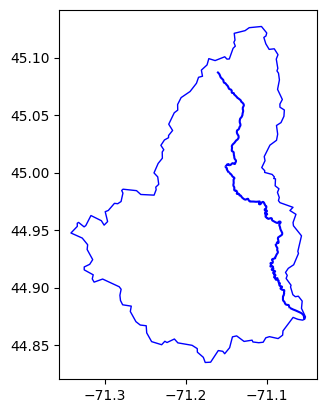

In [ ]:
import matplotlib.pyplot as plt
# example of a basin
fig, ax = plt.subplots()
basin.plot(ax=ax, facecolor="none", edgecolor="blue")
flw_main.plot(ax=ax, color="blue")


In [4]:
from engine import Engine
import torch
e = Engine(config_path="./config/test.yaml")
e # print the model structure

GraphWaveNet(
  (input): Conv2d(7, 16, kernel_size=(1, 1), stride=(1, 1))
  (static_emb): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
  )
  (tcn_a): ModuleList(
    (0): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(4, 4))
    (3): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(8, 8))
  )
  (tcn_b): ModuleList(
    (0): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(4, 4))
    (3): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(8, 8))
  )
  (gat): ModuleList(
    (0-3): 4 x GATConv(16, 16, heads=4)
  )
  (bn): Module

c:\Users\82105\GATWN\GATWN\dataset.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weather = torch.tensor(self.weather, dtype=torch.float32)


When training is executed, the model results will be saved in the project path specified within test.yaml.

In [ ]:
e.train_full(ev=True) # train and evaluate the model locally to one specific catchment

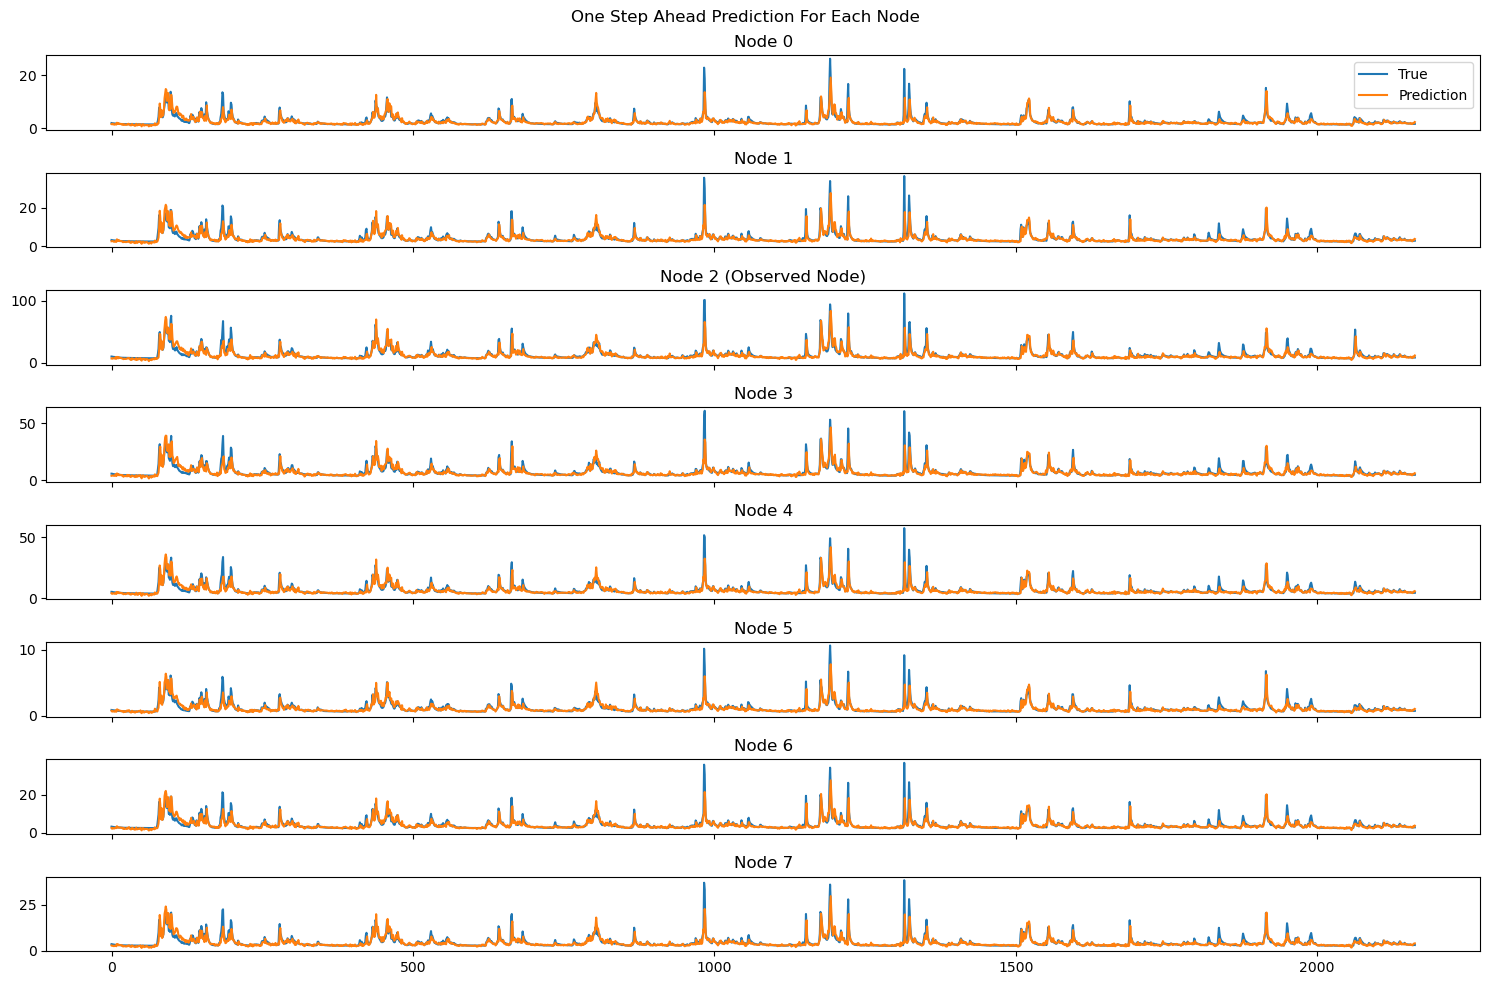

In [9]:
# 3번째 epoch 결과를 불러와 예측 결과를 확인해보겠습니다.
import torch
import matplotlib.pyplot as plt
from dataset import DynamicGraphDataset
import yaml
ds = DynamicGraphDataset(config=yaml.safe_load(open("./config/test.yaml")), gauge_id="01052500", ds_type="eval")

obs_idx = ds.outlet_idx # 2 is the outlet index of the catchment
num_nodes = ds.num_nodes
d = torch.load('runs/test/checkpoint/checkpoint_epoch_4.pt')
y_pred = d["results"]["01052500"]["y_pred"]
y_true = d["results"]["01052500"]["y_true"]
y_pred.shape, y_true.shape # (Time, Prediction Length, Number of nodes), (Time, Prediction Length, Number of nodes)

# We can plot one step ahead prediction for each node

fig, ax = plt.subplots(num_nodes, 1, figsize=(15, 10), sharex=True)
for i in range(num_nodes):
    ax[i].plot(y_true[:, 0, i], label="True")
    ax[i].plot(y_pred[:, 0,i], label="Prediction")
    ax[i].set_title(f"Node {i}")
    
    if i == 0:
        ax[i].legend()
    if i == obs_idx:
        ax[i].set_title(f"Node {i} (Observed Node)")

fig.suptitle("One Step Ahead Prediction For Each Node")
plt.tight_layout()

Furthermore, you can load pre-trained models to perform evaluations.

In [21]:
from engine import Engine
import torch
pretrained = torch.load("./runs/global/checkpoint/checkpoint_epoch_30.pt")
e = Engine(config_path="./config/test2.yaml") # test2.yaml is the same as test.yaml except for the project folder directory (for fine-tuning)
e.model.load_state_dict(pretrained["model_state_dict"]) # load the pretrained model

GraphWaveNet(
  (input): Conv2d(7, 16, kernel_size=(1, 1), stride=(1, 1))
  (static_emb): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
  )
  (tcn_a): ModuleList(
    (0): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(4, 4))
    (3): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(8, 8))
  )
  (tcn_b): ModuleList(
    (0): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(4, 4))
    (3): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(8, 8))
  )
  (gat): ModuleList(
    (0-3): 4 x GATConv(16, 16, heads=4)
  )
  (bn): Module

c:\Users\82105\GATWN\GATWN\dataset.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weather = torch.tensor(self.weather, dtype=torch.float32)


<All keys matched successfully>

In [11]:
_, pt_results = e.evaluate()

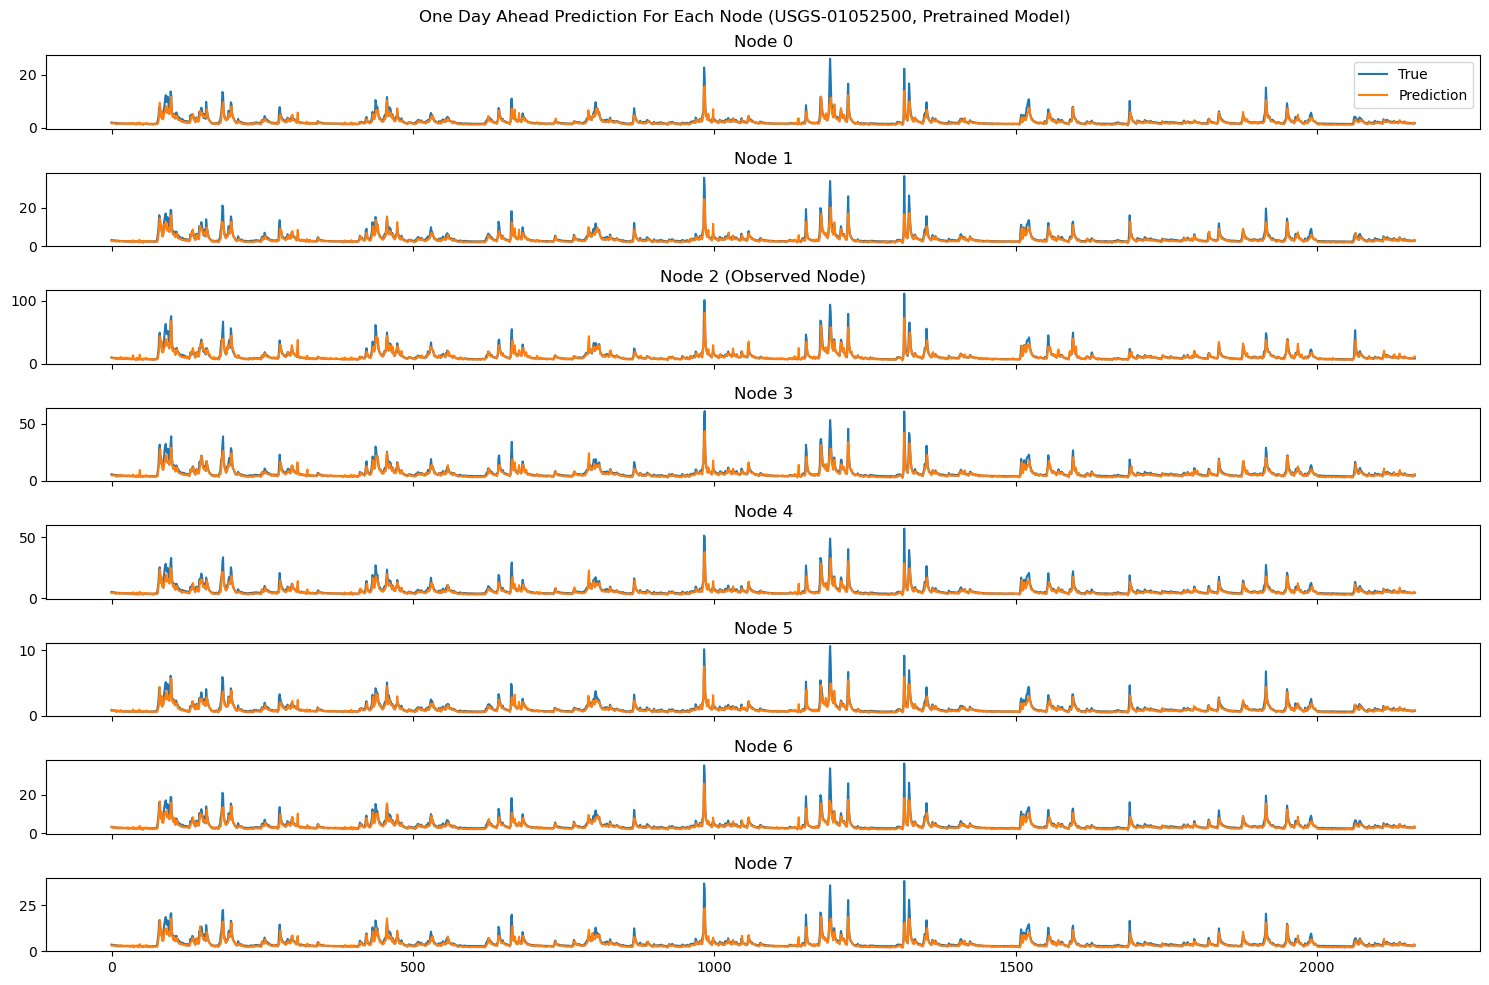

In [20]:
pt_y_pred = pt_results["01052500"]["y_pred"]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(num_nodes, 1, figsize=(15, 10), sharex=True)
for i in range(num_nodes):
    ax[i].plot(y_true[:, 0, i], label="True")
    ax[i].plot(pt_y_pred[:, 0,i], label="Prediction")
    ax[i].set_title(f"Node {i}")
    
    if i == 0:
        ax[i].legend()
    if i == obs_idx:
        ax[i].set_title(f"Node {i} (Observed Node)")

fig.suptitle("One Day Ahead Prediction For Each Node (USGS-01052500, Pretrained Model)")
plt.tight_layout()

In [ ]:
# finetuning the model for the specific catchment
# we can reduce the number of epochs to 7 (fine-tuning is usually faster than training from scratch)
e.config['train']['epochs'] = 7
e.train_full(ev=True)

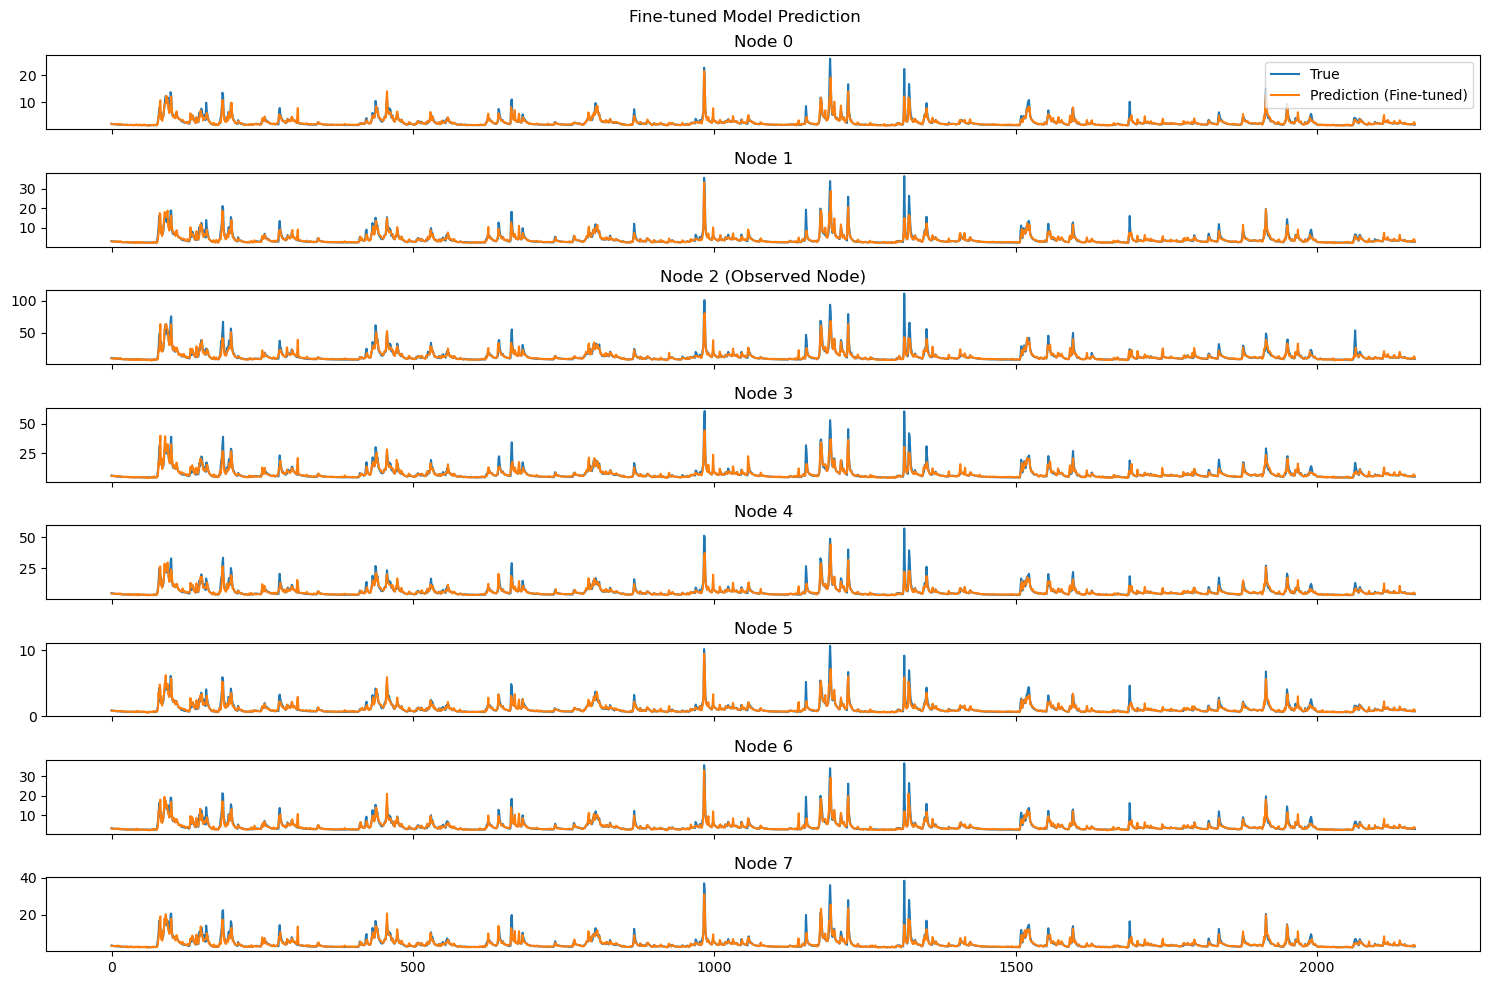

In [ ]:
e.use_only_loss_obs = False
_, ft_results = e.evaluate()
ft_y_pred = ft_results["01052500"]["y_pred"]


fig, ax = plt.subplots(num_nodes, 1, figsize=(15, 10), sharex=True)
for i in range(num_nodes):
    ax[i].plot(y_true[:, 0, i], label="True")
    ax[i].plot(ft_y_pred[:, 0,i], label="Prediction (Fine-tuned)")
    ax[i].set_title(f"Node {i}")
    
    if i == 0:
        ax[i].legend()
    if i == obs_idx:
        ax[i].set_title(f"Node {i} (Observed Node)")

fig.suptitle("Fine-tuned Model Prediction")
plt.tight_layout()

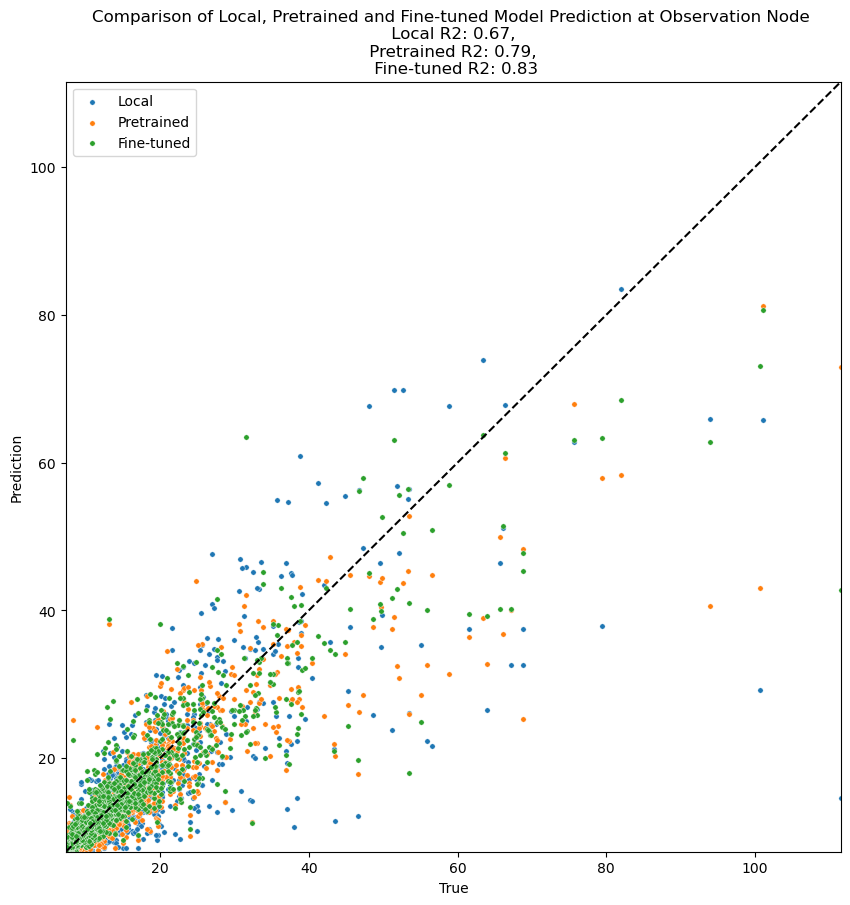

In [19]:
# Lastly, we can compare the results of the locally trained model, pretrained model and the fine-tuned model at Observation Node
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score

df = pd.DataFrame({"Local": y_pred[:, 0, obs_idx], "Pretrained": pt_y_pred[:, 0, obs_idx], "Fine-tuned": ft_y_pred[:, 0, obs_idx], "True": y_true[:, 0, obs_idx]})
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=df, x="True", y="Local", label="Local", ax=ax, s=15) # adjust marker size with s=100
sns.scatterplot(data=df, x="True", y="Pretrained", label="Pretrained", ax=ax, s=15)
sns.scatterplot(data=df, x="True", y="Fine-tuned", label="Fine-tuned", ax=ax, s=15)

ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.legend()
ax.set_xlim(df["True"].min(), df["True"].max())
ax.set_ylim(df["True"].min(), df["True"].max())
ax.plot([df["True"].min(), df["True"].max()], [df["True"].min(), df["True"].max()], ls="--", c="black")
r2_local = r2_score(df["True"], df["Local"])
r2_pretrained = r2_score(df["True"], df["Pretrained"])
r2_finetuned = r2_score(df["True"], df["Fine-tuned"])
ax.set_title("Comparison of Local, Pretrained and Fine-tuned Model Prediction at Observation Node \n Local R2: {:.2f}, \n Pretrained R2: {:.2f}, \n Fine-tuned R2: {:.2f}".format(r2_local, r2_pretrained, r2_finetuned))
plt.show()


GraphWaveNet(
  (input): Conv2d(7, 16, kernel_size=(1, 1), stride=(1, 1))
  (static_emb): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
  )
  (tcn_a): ModuleList(
    (0): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(4, 4))
    (3): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(8, 8))
  )
  (tcn_b): ModuleList(
    (0): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(4, 4))
    (3): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(8, 8))
  )
  (gat): ModuleList(
    (0-3): 4 x GATConv(16, 16, heads=4)
  )
  (bn): Module

c:\Users\82105\GATWN\GATWN\dataset.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weather = torch.tensor(self.weather, dtype=torch.float32)


(2163, 7, 30)
tensor(3)


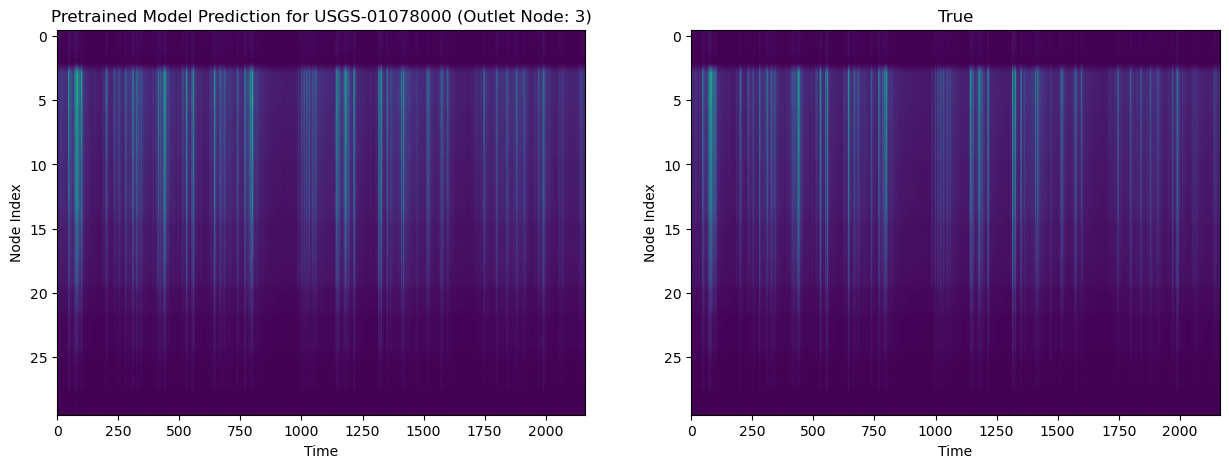

In [ ]:
# And also we would like to see the flexibility of the model to predict the other catchment when the number of nodes is different
pretrained = torch.load("./runs/global/checkpoint/checkpoint_epoch_30.pt")
e = Engine(config_path="./config/test3.yaml") # USGS-13310700 
e.model.load_state_dict(pretrained["model_state_dict"])
_, new_catchment_pt_results = e.evaluate()
new_catchment_pt_y_pred = new_catchment_pt_results["01078000"]["y_pred"]
new_catchment_pt_y_true = new_catchment_pt_results["01078000"]["y_true"]
print(new_catchment_pt_y_pred.shape) # (Time, Prediction Length, Number of nodes) (2163, 7, 30)
ds = DynamicGraphDataset(config=yaml.safe_load(open("./config/test3.yaml")), gauge_id="01078000", ds_type="eval")
print(ds.outlet_idx) # 3 is the outlet index of the catchment
new_outlet_idx = ds.outlet_idx
new_number_of_nodes = ds.num_nodes
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
ax[0].imshow(new_catchment_pt_y_pred[:, 0, :].T, aspect="auto")
ax[0].set_title("Pretrained Model Prediction for USGS-01078000 (Observed Node: 3)")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Node Index")
ax[1].imshow(new_catchment_pt_y_true[:, 0, :].T, aspect="auto")
ax[1].set_title("True")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Node Index")
plt.show()


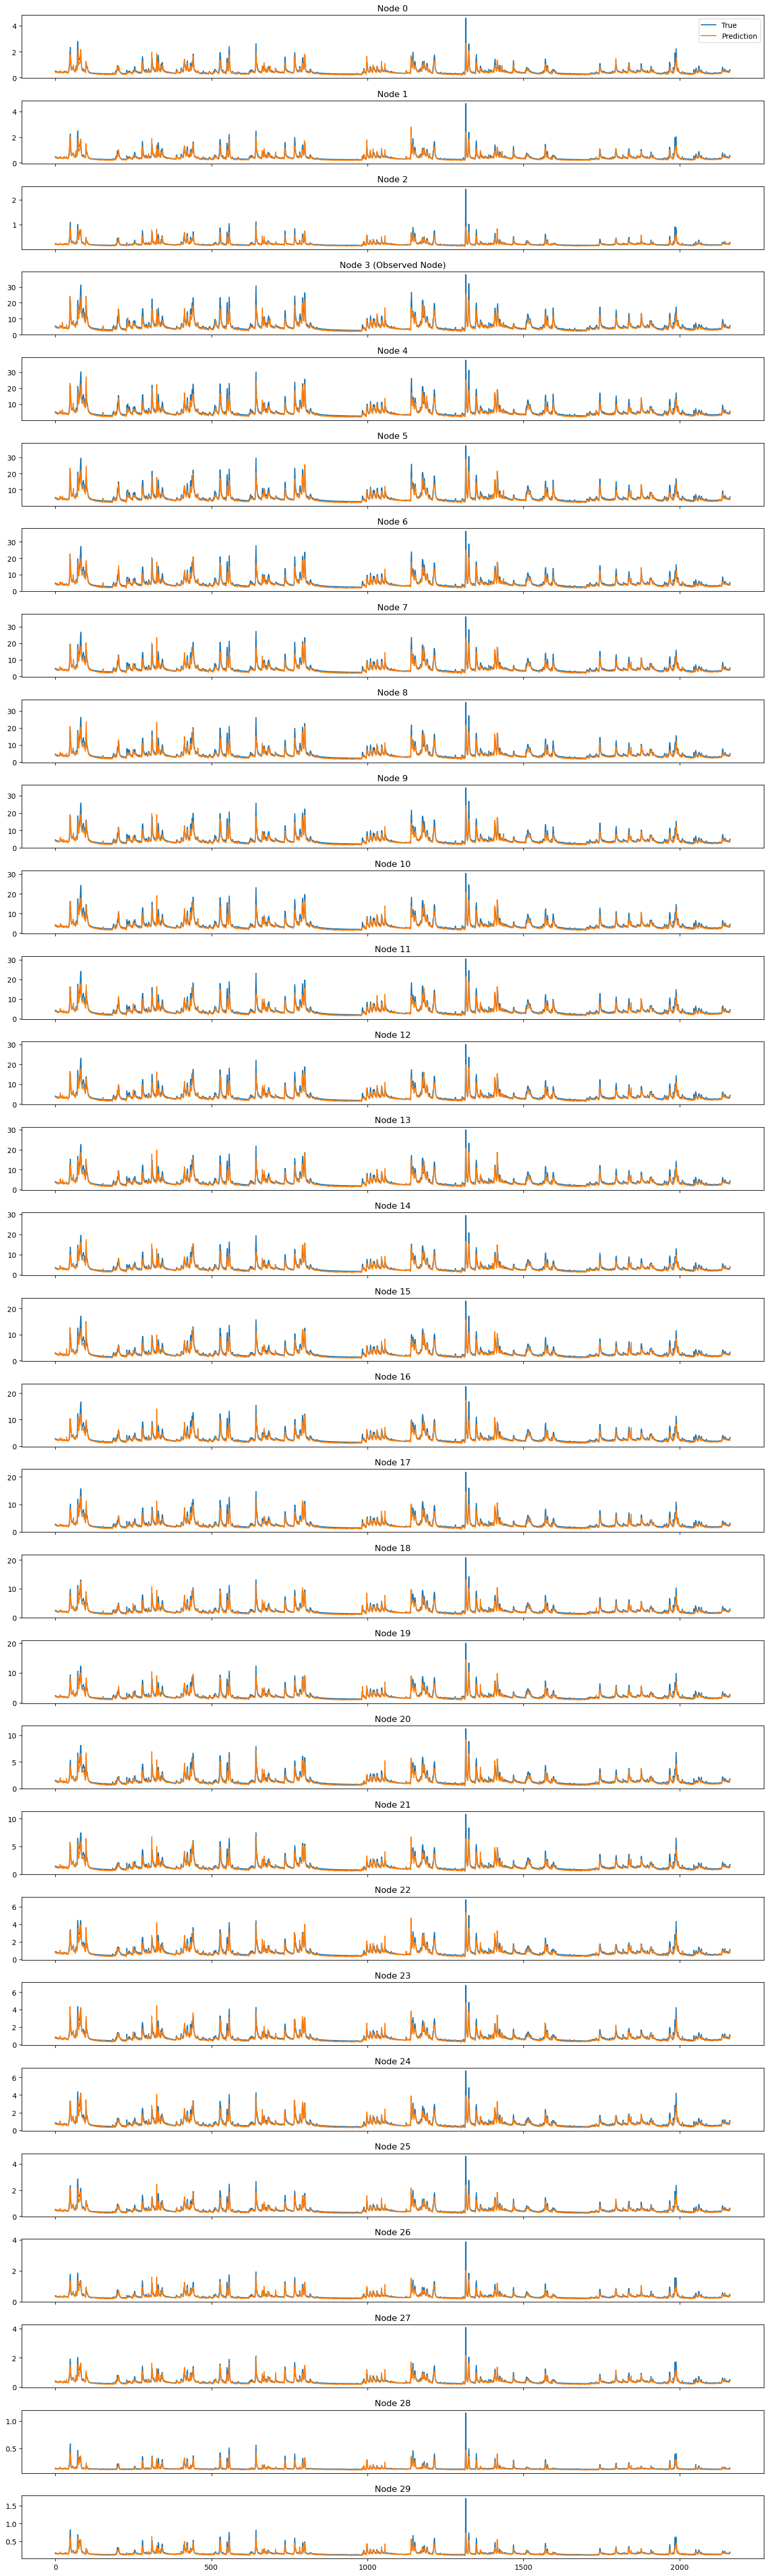

In [39]:
fig, ax = plt.subplots(new_number_of_nodes, 1, figsize=(15, 50), sharex=True)
for i in range(new_number_of_nodes):
    ax[i].plot(new_catchment_pt_y_true[:, 0, i], label="True")
    ax[i].plot(new_catchment_pt_y_pred[:, 0,i], label="Prediction")
    ax[i].set_title(f"Node {i}")
    
    if i == 0:
        ax[i].legend()
    if i == new_outlet_idx:
        ax[i].set_title(f"Node {i} (Observed Node)")

plt.tight_layout()

In [41]:
from pynhd import NLDI, WaterData, NHDPlusHR, GeoConnex
import geopandas as gpd
import pandas as pd
import pynhd as nhd
nldi = NLDI()
station_id = "01078000"
basin = nldi.get_basins(station_id)
flw_main = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamMain",
    source="flowlines",
    distance=1000,
)

In [ ]:
d = torch.load("./data/preprocessed/01078000.pt")
flw_main.set_index("nhdplus_comid", inplace=True)


In [58]:
flw_main.index = flw_main.index.astype(int)
flw_main = flw_main.loc[d["comids"]] 

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_40248\2661930055.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


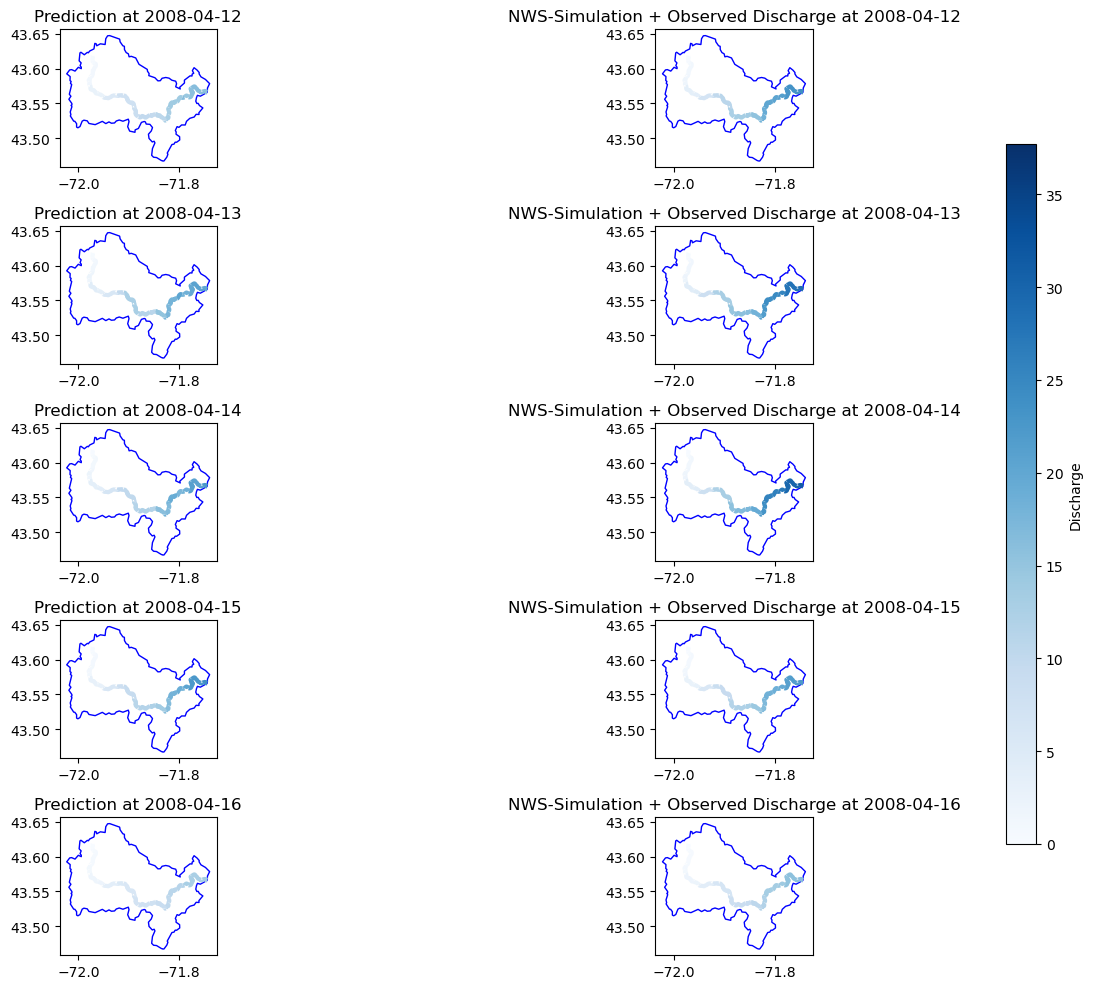

In [ ]:
import matplotlib.colors as colors
import pandas as pd

date_range = pd.date_range(e.config["data"]["eval_start"], e.config["data"]["eval_end"], freq="D")
date_range = date_range[22:-7]
discharge_max, discharge_min = new_catchment_pt_y_true[:, 0, 3].max(), 0
fig, ax = plt.subplots(5, 2, figsize=(15, 10))
date_idxs = [ 80 + i for i in range(5)]




norm = colors.Normalize(vmin=discharge_min, 
                       vmax=discharge_max)
cmap = plt.cm.Blues  
for i, date_idx in enumerate(date_idxs):
    flw_main["discharge"] = new_catchment_pt_y_pred[date_idx, 0,:]
    basin.plot(ax=ax[i][0], facecolor="none", edgecolor="blue")
    flw_main.plot(ax=ax[i][0], color=cmap(norm(flw_main["discharge"])), 
                linewidth=3)
    ax[i][0].set_title(f"Prediction at {date_range[date_idx].strftime('%Y-%m-%d')}")
    flw_main["discharge"] = new_catchment_pt_y_true[date_idx, 0,:]
    basin.plot(ax=ax[i][1], facecolor="none", edgecolor="blue")
    flw_main.plot(ax=ax[i][1], color=cmap(norm(flw_main["discharge"])), 
                linewidth=3)
    ax[i][1].set_title(f"NWS-Simulation + Observed Discharge at {date_range[date_idx].strftime('%Y-%m-%d')}")
fig.subplots_adjust(right=0.85) # Make space for colorbar
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
colorbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                       cax=cbar_ax,
                       orientation='vertical', 
                       label='Discharge')
plt.tight_layout()